# Anomaly score differences with aggregation order
Uncover if the order of aggregation substantially influences the anomaly score
The two operations are:
- Aggregated Profile: Aggregated single-cell profiles to treatment level -> Trained with anomalyze to compute anomaly scores
- Aggregated Anomaly Score: Trained with anomalyze to compute anomaly scores -> Aggregated single-cell anomaly scores to treatment level

In [1]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Find the root of the git repo on the host system

In [2]:
# Get the current working directory
cwd = pathlib.Path.cwd()

if (cwd / ".git").is_dir():
    root_dir = cwd

else:
    root_dir = None
    for parent in cwd.parents:
        if (parent / ".git").is_dir():
            root_dir = parent
            break

# Check if a Git root directory was found
if root_dir is None:
    raise FileNotFoundError("No Git root directory found.")

## Inputs

In [3]:
agg_anomdf = pd.read_parquet(
    root_dir
    / "big_drive/aggregated_anomaly_data/aggregated_treatment_anomaly_data.parquet"
)

sc_anom_paths = (
    root_dir / "big_drive/sc_anomaly_data/feature_selected_sc_qc_data"
).resolve(strict=True)

## Outputs

In [4]:
figures_path = pathlib.Path("figures")
figures_path.mkdir(parents=True, exist_ok=True)

## Aggregate Anomaly Scores to Treatment Level

In [5]:
agg_platedf = []

for plate_path in sc_anom_paths.iterdir():

    treatment_col_name = "Metadata_pert_iname"
    platedf = pd.concat(
        [
            pd.read_parquet(data_path)
            for data_path in list(plate_path.rglob("*.parquet"))
        ],
        axis=0,
    )

    result_cols = platedf.columns[platedf.columns.str.contains("Result")]

    agg_mapping = dict.fromkeys(result_cols, "mean")
    agg_mapping |= {"Metadata_Plate": "first"}

    # Distinguish between Compound data and (CRISPR and ORF data)
    if not np.any(platedf.columns.str.contains(treatment_col_name)):
        treatment_col_name = "Metadata_gene"

    agg_platedf.append(
        platedf.groupby(treatment_col_name).agg(agg_mapping).reset_index()
    )

agg_platedf = pd.concat(agg_platedf, axis=0)

## Merge Aggregated Anomaly Data

In [6]:
all_anomdf = pd.merge(
    agg_platedf,
    agg_anomdf,
    how="inner",
    on=["Metadata_Plate", "Metadata_gene", "Metadata_pert_iname"],
    suffixes=("_aggregated_anomaly_score", "_aggregated_profile"),
)

## Plot Anomaly Scores according to Aggregation Order

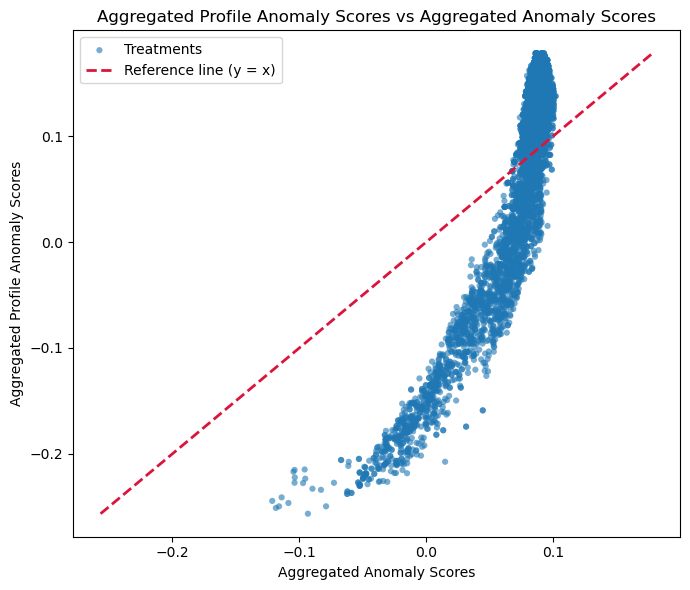

Reference line slope: 1.0, Intercept: 0.0, R^2 (vs y=x): 0.1075, MSE: 0.004624, MAE: 0.062342


In [7]:
x_col = "Result_anomaly_score_aggregated_anomaly_score"
y_col = "Result_anomaly_score_aggregated_profile"

plot_df = all_anomdf[[x_col, y_col]].dropna()
x = plot_df[x_col].to_numpy()
y = plot_df[y_col].to_numpy()

# Reference line: y = x (slope=1, intercept=0)
y_identity = x

# R^2 scores
ss_res = np.sum((y - y_identity) ** 2)
ss_tot = np.sum((y - y.mean()) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Error metrics against the identity line
mse = np.mean((y - y_identity) ** 2)
mae = np.mean(np.abs(y - y_identity))

plt.figure(figsize=(7, 6))
plt.scatter(x, y, s=20, alpha=0.6, edgecolor="none", label="Treatments")
line_min = min(x.min(), y.min())
line_max = max(x.max(), y.max())
plt.plot(
    [line_min, line_max],
    [line_min, line_max],
    color="crimson",
    linewidth=2,
    linestyle="--",
    label="Reference line (y = x)",
)
plt.xlabel("Aggregated Anomaly Scores")
plt.ylabel("Aggregated Profile Anomaly Scores")
plt.title("Aggregated Profile Anomaly Scores vs Aggregated Anomaly Scores")
plt.legend()
plt.tight_layout()
plt.savefig(figures_path / "anomaly_comparisons.png", dpi=300, bbox_inches="tight")
plt.show()

print(
    f"Reference line slope: 1.0, Intercept: 0.0, R^2 (vs y=x): {r2:.4f}, "
    f"MSE: {mse:.6f}, MAE: {mae:.6f}"
)